In [34]:
import sys
sys.path.append("../")
sys.path.append("../covid19_inference")
from header_plotting import *

# Getting started

As running our model on multiple countries and different priors may need a good amount of time, we wanted to to show you how to run our most simple analysis for a single country.

## Loading data

We supply case data with gender metadata for a number of countries, the csv files can be found in the `data` folder. As we needed to extract alot of different features from the data and wanted to combine accelarating data (such as the UEFA2020 timetable), we developed a data loader. This dataloader and all the functionalities can be found in `covid19_soccer/dataloader.py`. The python file holds two class definitions, one dataloder accounting for gender data and another one without gender data.

In [17]:
import covid19_soccer
from datetime import datetime

## Load data via dataload
country = "Scotland"
data_begin = datetime(2021, 6, 4)
data_end = datetime(2021, 7, 18)
dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country],data_begin=data_begin,data_end=data_end,)

For example we can get the population numbers of the number or the stadium size of all stadiums in the country.

In [18]:
print(f"Population in {country}:\n\tMale:{dl.population[0]}\n\tFemale:{dl.population[1]}\n")
print(f"Stadium size in {country}:\n\t{dl.stadium_size}")

Population in Scotland:
	Male:[2567400.]
	Female:[2728000.]

Stadium size in Scotland:
	[52500]


## Creating our model

For the mathematically rigorous explanation of our model see our puplication!

We wrote an easy wraper function for creating our model with different parameters or compartments enabled. The create model function can be found in `covid19_soccer/models.py`. Again we developed two functions one using the gender dataloader and another one without gender metadata. We can pass our previously created dataload easily to the function.

In [23]:
## Create model
soccer_model = covid19_soccer.models.create_model_gender(dataloader=dl,beta=False)

INFO     [covid19_soccer.utils] pr_sigma_lambda was set to default value 0.2
INFO     [covid19_soccer.utils] pr_median_lambda was set to default value 0.125
INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_soccer.effect_gender] R_t_soccer with deltas
INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_E
INFO     [covid19_soccer.compartmental_models] kernelized spread soccer
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_soccer.delay_by_weekday] Delaying cases by weekday
INFO     [covid19_inference.model.week_modulation] Week modulation


## Sampling

We can sample the posterior of our model using mcmc methods. PyMC3 implements most, if not all algorithms which you may want to use. For our main analysis we used the NoU-TurnSsampler. Keep in mind that we had access to HPC and thus were able to run a high number of chains in parallel. We also run way more tuning steps for our main analysis, the following will maybe take 1-2 hours with a normal desktop processor.

In [ ]:
import pymc3 as pm

trace = pm.sample(
    draws=500,
    tune=500,
    model=soccer_model,
    return_inferencedata=True
)


Best practice after sampling is to save the trace and model, such that you can load it at a later point in time without haveing to sample it again.

In [31]:
import pickle

with open("../data/example_scotland_model_trace.pkl", "wb") as f:
        pickle.dump((model, trace), f)

If you dont feel like sampling for that long you can also load the example trace to play a bit with it. 

In [38]:
def load(fstr):
    with open(fstr, "rb") as f:
         return pickle.load(f)
        
model_soccer, trace = load("../data/example_scotland_model_trace.pkl")

## Overview of posterior and sample stats

The next step after running the sampling is normally to have a look at the convergences of the chains, you can e.g. do that with rhat stats. After confirming that the sampling converged we can have a look at our posterior distributions. For that reason we developed a number of plotting routines, these can be found in `covid19_soccer/plot/*`. 

../covid19_soccer/plot/other.py:692: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_posterior, lw=0,),)


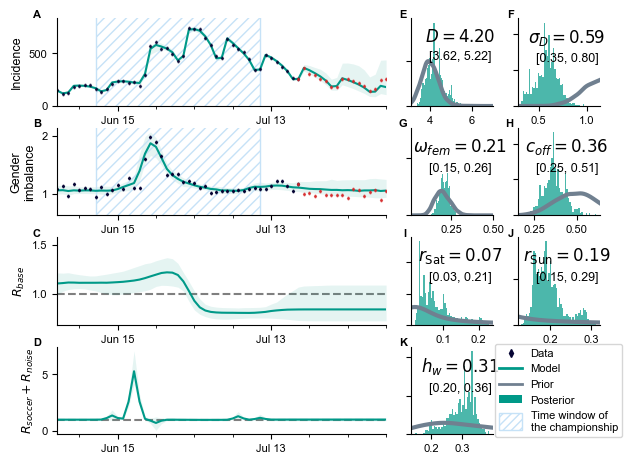

In [39]:
import matplotlib.pyplot as plt
fig = covid19_soccer.plot.overview.single_extended(trace,soccer_model,dl)
plt.show()
